# Simulation - Projet

## Importation des modules nécessaires


In [42]:
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
import math

## Lecture du fichier d'entrée

In [43]:
def e_numbers():
    with open("exp.txt", "r") as e:
        for line in e:
            line = line.strip()
            if "." in line:
                line = line.split(".")[1]
            for c in line:
                yield int(c)

e_numbers = np.array(list(e_numbers()))
print(f'Les 2.000.000 premières décimales d\' exp :\n {e_numbers}')

Les 2.000.000 premières décimales d' exp :
 [7 1 8 ... 0 2 3]


## Compter effectif

In [44]:
def count_number(data):
    values, counts = np.unique(data, return_counts=True)
    return values, counts

e_labels, e_counts = count_number(e_numbers)
print(f'Les chiffres apparaissant dans les décimales d\' exp : \n {e_labels}')
print(f'Leur fréquences d\'apparition : \n {e_counts}')

Les chiffres apparaissant dans les décimales d' exp : 
 [0 1 2 3 4 5 6 7 8 9]
Leur fréquences d'apparition : 
 [199093 200171 199471 200361 199923 200285 200395 199789 200098 200414]


## Construire histogramme


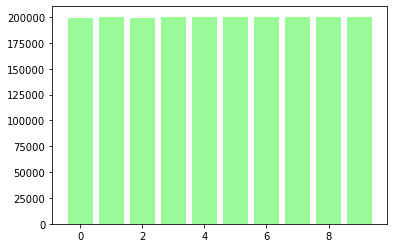

In [45]:
def construct_hist(labels, counts):
    fig, ax = plt.subplots()
    ax.bar(labels, counts, color='palegreen')
    plt.show()

construct_hist(e_labels, e_counts)

## Test du Chi-Carré

In [46]:
def chi_squared_uniform(counts):
    pi = 1 / len(counts)
    N = sum(counts)
    kr = np.sum(((counts-(N*pi))/(math.sqrt(N*pi)))**2)
    critical = stat.chi2.ppf(q=0.95, df=9)
    return kr <= critical, kr, critical

print(f'Le résultat de notre test du Chi-Carré est : \n {chi_squared_uniform(e_counts)}')

Le résultat de notre test du Chi-Carré est : 
 (True, 8.65376, 16.918977604620448)


## Test de Kolmogorov-Smirnov

In [47]:
def kolmogorov_smirnov(labels, counts):
    assert len(labels) == len(counts)
    proba = 1 / len(counts)
    N = np.sum(counts)
    real_repartition = np.cumsum(counts, axis=0)/N
    th_repartition = np.cumsum(np.full(len(labels), proba))
    maximum = np.max(np.abs(real_repartition-th_repartition))
    critical = 1.358/math.sqrt(N/len(labels))
    return maximum < critical, maximum, critical

print(kolmogorov_smirnov(e_labels, e_counts))

(True, 0.0006325000000000358, 0.0030365803134447147)


## Test du Poker

In [48]:
def poker_test(data, labels, counts):
    number_lists = len(data)/4
    lists = np.split(data, number_lists)
    all_diff = 0
    one_pair = 0
    two_pair = 0
    triplet = 0
    quadr = 0
    for li in lists:
        vals, cts = np.unique(li, return_counts=True)
        if len(cts) == 4:
            all_diff += 1
        elif len(cts) == 3:
            one_pair += 1
        elif len(cts) == 2:
            if 3 in cts:
                triplet += 1
            else:
                two_pair += 1
        else:
            quadr += 1
    return chi_squarred_poker(np.array([all_diff, one_pair, triplet, two_pair, quadr]), len(lists))

def chi_squarred_poker(observed, N):    # P(all_diff) > P(one_pair) > P(triplet) > P(two_pair) > P(quadr)
    probas = np.array([0.504, 0.432, 0.036, 0.027, 0.001])
    theorical = probas * N
    kr = np.sum(((observed-theorical)**2)/theorical)
    critical = stat.chi2.ppf(q=0.95, df=4)
    return kr <= critical, kr, critical

print(poker_test(e_numbers, e_labels, e_counts))

(True, 1.2631547619047618, 9.487729036781154)


## Test du gap

In [49]:
def gap_test(data, a: int = 0, b: int = 5, total_numbers: int = 10):
    assert a < b
    probability = (b - a) / total_numbers  # => proba 1/2 d'être marqué
    intervals = []
    length_series_not_in = 0
    total_gaps = 0
    sequence_length = 0
    for nb in data:
        if a <= nb < b:
            # nb in interval, with probability `probability`
            intervals.append(length_series_not_in)
            length_series_not_in = 1
        else:
            # nb not in interval
            length_series_not_in += 1
            total_gaps += 1
        sequence_length += 1
    labels, observed = np.unique(np.array(intervals), return_counts=True)
    observed = np.cumsum(complete_labels(labels, observed)/sequence_length)
    theorical = np.cumsum(np.array([probability ** (n + 1) for n in range(max(labels))]))
    kr = np.sum(((observed - theorical) ** 2) / theorical)
    crit = stat.chi2.ppf(q=0.05, df=len(observed) - 1)
    return kr <= crit, kr, crit

def complete_labels(labels, observed):
    i = 1
    j = 0
    n = 1
    res = []
    while j < len(labels):
        label = labels[j]
        if i != label:
            res.append(0)
            n += 1
        else:
            res.append(observed[i-n])
            j += 1
        i += 1
    return np.array(res)

gap_test(e_numbers)

(True, 5.5117785465143285, 12.338014578790643)

## Generateur

In [54]:
NB_DIGITS = 10

def generator(n: int = 1, seed_: int = 0):
    for i in range(n):
        xyz = []
        for j in range(3):
            digits = []
            for k in range(NB_DIGITS):
                seed = e_numbers[seed_ + i + j + k]
                a = len(e_numbers) - seed
                c = e_numbers[i + seed]
                digit = (a * seed + c) % 10
                digits.append(digit)
            xyz.append(float("0." + "".join(map(lambda x: str(x), digits))))
        yield math.sqrt(sum([x**2 for x in xyz]))/math.sqrt(3)

gen = list(generator(1000, 50))
print(count_number(gen))

.2613255166]
[]
[0.9961924644]
[0.9961924644, 0.9619246444]
[]
[0.749271411]
[0.749271411, 0.4927141107]
[]
[0.2605627795]
[0.2605627795, 0.6056277956]
[]
[0.2934966232]
[0.2934966232, 0.9349662321]
[]
[0.602599701]
[0.602599701, 0.0259970101]
[]
[0.6944426479]
[0.6944426479, 0.9444264796]
[]
[0.5799659265]
[0.5799659265, 0.7996592652]
[]
[0.233484028]
[0.233484028, 0.3348402802]
[]
[0.1193881381]
[0.1193881381, 0.1938813813]
[]
[0.6486548548]
[0.6486548548, 0.4865485482]
[]
[0.0211921927]
[0.0211921927, 0.2119219271]
[]
[0.060400401]
[0.060400401, 0.6040040104]
[]
[0.2385385939]
[0.2385385939, 0.3853859397]
[]
[0.8608604832]
[0.8608604832, 0.6086048323]
[]
[0.1631693161]
[0.1631693161, 0.6316931611]
[]
[0.5765576466]
[0.5765576466, 0.7655764665]
[]
[0.5264519124]
[0.5264519124, 0.2645191245]
[]
[0.165074715]
[0.165074715, 0.6507471508]
[]
[0.0556062555]
[0.0556062555, 0.5560625553]
[]
[0.9179729183]
[0.9179729183, 0.1797291839]
[]
[0.0707610861]
[0.0707610861, 0.7076108613]
[]
[0.1018